 **The features you create are different for every dataset, so it takes a bit of creativity and experimentation**.
 
 We're a bit limited here, since we're working with only one table. Typically you'll have access to multiple tables with relevant data that you can use to create new features.

In [21]:
import pandas as pd
import numpy as np

df = pd.read_csv('ks-projects-201801.csv')
df_cleaned = pd.read_csv('cleaned_data.csv')
df['state'] = df_cleaned['state']

## Interactions

One of the easiest ways to create new features is by combining categorical variables. For example, if one record has the country "CA" and category "Music", you can create a new value "CA_Music". **This is a new categorical feature that can provide information about correlations between categorical variables.** This type of feature is typically called an **interaction**

In [2]:
# it's very easy with pandas
df['category_country'] = df['category'] + '_' + df['country']

In [3]:
df[['category', 'country', 'category_country']].head(10)

,category,country,category_country
0,Poetry,GB,Poetry_GB
1,Narrative Film,US,Narrative Film_US
2,Narrative Film,US,Narrative Film_US
3,Music,US,Music_US
4,Film & Video,US,Film & Video_US
5,Restaurants,US,Restaurants_US
6,Food,US,Food_US
7,Drinks,US,Drinks_US
8,Product Design,US,Product Design_US
9,Documentary,US,Documentary_US


### Number of projects in the last week

Count the number of projects launched in the preceeding week for each record.

In [9]:
df['launched'] = pd.to_datetime(df['launched'])
launched = pd.Series(df.index, index = df.launched, name='count_7_days').sort_index()

**Good to know: **
- With a timeseries index, you can use **.rolling** to select time periods as the window. For example launched.rolling('7d') creates a rolling window that contains all the data in the previous 7 days. The window contains the current record, so if we want to count all the previous projects but not the current one, we'll need to subtract 1. 

In [11]:
# .
count_7_days = launched.rolling('7d').count() - 1
count_7_days

launched
1970-01-01 01:00:00      0.0
1970-01-01 01:00:00      1.0
1970-01-01 01:00:00      2.0
1970-01-01 01:00:00      3.0
1970-01-01 01:00:00      4.0
1970-01-01 01:00:00      5.0
1970-01-01 01:00:00      6.0
2009-04-21 21:02:48      0.0
2009-04-23 00:07:53      1.0
2009-04-24 21:52:03      2.0
2009-04-25 17:36:21      3.0
2009-04-27 14:10:39      4.0
2009-04-28 13:55:41      5.0
2009-04-29 02:04:21      5.0
2009-04-29 02:58:50      6.0
2009-04-29 04:37:37      7.0
2009-04-29 05:26:32      8.0
2009-04-29 06:43:44      9.0
2009-04-29 13:52:03     10.0
2009-04-29 22:08:13     11.0
2009-04-29 23:11:15     12.0
2009-04-30 01:32:55     12.0
2009-04-30 07:14:06     13.0
2009-04-30 22:10:30     14.0
2009-04-30 22:22:43     15.0
2009-04-30 22:23:22     16.0
2009-05-01 05:06:19     17.0
2009-05-01 14:22:21     18.0
2009-05-01 17:44:25     19.0
2009-05-01 17:51:24     20.0
                       ...  
2018-01-02 03:05:10    435.0
2018-01-02 03:24:13    435.0
2018-01-02 03:26:52    436.0
2018-

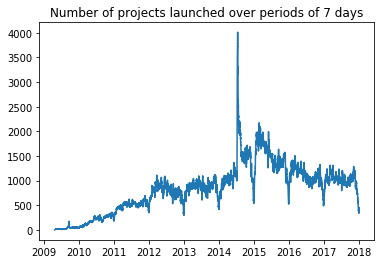

In [15]:
import matplotlib.pyplot as plt
# Ignore records with broken launch dates

plt.plot(count_7_days[7:]);
plt.title("Number of projects launched over periods of 7 days");
plt.show()

Now that we have the counts, we need to adjust the index so we can join it with the main dataframe

In [16]:
count_7_days.index = launched.values
count_7_days = count_7_days.reindex(df.index)

In [22]:
df = df.join(count_7_days)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,count_7_days
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0.0,0,GB,0.0,0.0,1533.95,1409.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0.0,15,US,100.0,2421.0,30000.00,957.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0.0,3,US,220.0,220.0,45000.00,739.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0.0,1,US,1.0,1.0,5000.00,907.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0.0,14,US,1283.0,1283.0,19500.00,1429.0


### Time since the last project in the same category

**Question:**
- Do projects in the same category compete for donors?

In [23]:
def time_since_last_project(series):
    # Return the time in hours
    return series.diff().dt.total_seconds()/3600

In [31]:
df['launched'] = pd.to_datetime(df['launched'])

aux_df = df[['category', 'launched']].sort_values('launched')
timedeltas = aux_df.groupby('category').transform(time_since_last_project)

In [32]:
# we get NaN here for projects that are first in their category
timedeltas

,launched
75397,NaN
319002,NaN
2842,0.000000
94579,NaN
247913,NaN
273779,NaN
48147,NaN
169268,NaN
322000,NaN
138572,NaN


### Transforming numerical features

The distribution of the values in "goal" shows that most projects have goals less than 5000 USD. However, there is a long tail of goals going up to $100,000. Some models work better when the features are **normally distributed**, so it might help to transform the goal values.

**Common choices for this are the square root and natural logarithm**

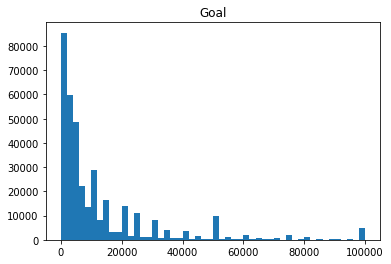

In [33]:
plt.hist(df.goal, range=(0, 100000), bins=50);
plt.title('Goal');

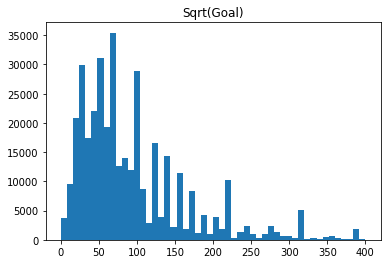

In [34]:
plt.hist(np.sqrt(df.goal), range=(0, 400), bins=50);
plt.title('Sqrt(Goal)');

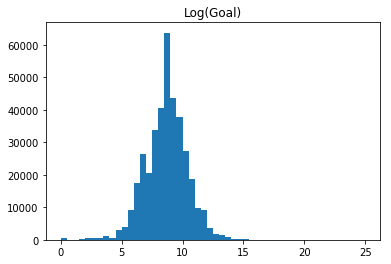

In [35]:
plt.hist(np.log(df.goal), range=(0, 25), bins=50);
plt.title('Log(Goal)');

**The log transformation would help in the cxase of a linear model or a neural network**